<a href="https://colab.research.google.com/github/valentinagliozzi/NNCourse/blob/main/a4Ibrido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio


In [3]:
#Utility functions definition
def a4_rand(requested_size, seed):
    global randomness_source
    start_i = (round(seed) % (randomness_source.shape[1] // 10)) + 1
    if start_i + np.prod(requested_size) >= randomness_source.shape[1] + 1:
        raise ValueError("a4_rand failed to generate an array of that size (too big)")
    ret = randomness_source[0][start_i : start_i + np.prod(requested_size)].reshape(
        requested_size
    )
    return ret


def extract_mini_batch(data_set, start_i, n_cases):
    mini_batch = {
        "inputs": data_set["inputs"][:, start_i : start_i + n_cases],
        "targets": data_set["targets"][:, start_i : start_i + n_cases],
    }
    return mini_batch


def sample_bernoulli(probabilities):
    global report_calls_to_sample_bernoulli
    if report_calls_to_sample_bernoulli:
        print(
            f"sample_bernoulli() was called with a matrix of size {probabilities.shape[0]} by {probabilities.shape[1]}."
        )
    seed = np.sum(probabilities)
    binary = (probabilities > a4_rand(probabilities.shape, seed)).astype(int)
    return binary


def visible_state_to_hidden_probabilities(rbm_w, visible_state):
    hidden_probability = 1 / (1 + np.exp(-np.dot(rbm_w, visible_state)))
    return hidden_probability


def hidden_state_to_visible_probabilities(rbm_w, hidden_state):
    visible_probability = 1 / (1 + np.exp(-np.dot(rbm_w.T, hidden_state)))
    return visible_probability


def cd1(rbm_w, visible_data):
    visible_data = sample_bernoulli(visible_data)

    t, m = visible_data.shape

    hidden_probabilities = visible_state_to_hidden_probabilities(rbm_w, visible_data)
    hidden_states = sample_bernoulli(hidden_probabilities)

    stati_hidden_stati_visible_0 = (hidden_states @ visible_data.T) / m

    visible_probabilities = hidden_state_to_visible_probabilities(rbm_w, hidden_states)
    visible_states = sample_bernoulli(visible_probabilities)

    hidden_probabilities1 = visible_state_to_hidden_probabilities(rbm_w, visible_states)
    hidden_states1 = hidden_probabilities1

    stati_hidden_stati_visible_1 = (hidden_states1 @ visible_states.T) / m

    ret = stati_hidden_stati_visible_0 - stati_hidden_stati_visible_1
    return ret


def show_rbm(rbm_w):
    n_hid = rbm_w.shape[0]
    n_rows = int(np.ceil(np.sqrt(n_hid)))
    blank_lines = 4
    distance = 16 + blank_lines
    to_show = np.zeros(
        (n_rows * distance + blank_lines, n_rows * distance + blank_lines)
    )

    for i in range(n_hid):
        row_i = i // n_rows
        col_i = i % n_rows
        pixels = rbm_w[i, :].reshape((16, 16)).T
        row_base = row_i * distance + blank_lines
        col_base = col_i * distance + blank_lines
        to_show[row_base : row_base + 16, col_base : col_base + 16] = pixels

    extreme = np.max(np.abs(to_show))
    try:
        plt.imshow(to_show, vmin=-extreme, vmax=extreme, cmap="gray")
        plt.title("hidden units of the RBM")
        plt.show()
    except Exception as err:
        print(
            "Failed to display the RBM. No big deal (you do not need the display to finish the assignment), but you are missing out on an interesting picture."
        )


def logistic(input):
    return 1 / (1 + np.exp(-input))


def comparec(a, b):
    k, n = a.shape
    ris = 0

    for i in range(n):
        if np.array_equal(a[:, i], b[:, i]):
            ris += 1

    d = n - ris
    p = (ris / n) * 100
    return d, p


def comparer(a, b):
    at = a.T
    bt = b.T
    d, p = comparec(at, bt)
    return d, p


def f(x):
    r, c = x.shape
    y = np.ones((r, c)) / (1 + np.exp(-x))
    return y


def retropro(Inp, Targ, nhid, Eta, Err, Nmax, seed):
    global rbm_w

    N, n = Inp.shape
    N1, z = Targ.shape
    Inp = np.hstack((Inp, np.ones((N, 1))))
    n = n + 1  # account for bias in hidden units

    if N != N1:
        print("Wrong dimensions\n\n")
        # break

    # Initialize weights randomly
    np.random.seed(seed)

    A = np.random.rand(nhid, n) - 0.5
    A = np.hstack((rbm_w, np.ones((nhid, 1))))
    B = np.random.rand(z, nhid + 1) - 0.5  # account for bias in hidden layer

    Inp = Inp.T
    Targ = Targ.T
    err = []

    c = 0
    ciclo = 0

    while ciclo == 0:
        Y = np.vstack(
            (f(np.dot(A, Inp)), np.ones((1, N)))
        )  # Output hidden plus 1 for bias
        R = f(np.dot(B, Y))
        q = (0.5 * np.ones((1, z)) @ ((R - Targ) ** 2)) @ np.ones((N, 1)) / N
        err.append(q.item())

        if q <= Err or c >= Nmax:
            ciclo = 1

        if ciclo == 0:
            c += 1
            for k in range(N):
                Yhid = f(np.dot(A, Inp[:, k]).reshape(-1,1))
                Out = f(np.dot(B, np.vstack((Yhid, 1))))
                DOut = (Targ[:, k].reshape(-1,1) - Out) * Out * (1 - Out)

                E = np.dot(DOut.T, B[:, :nhid])
                DYhid = E.T * Yhid * (1 - Yhid)
                B = B + Eta * np.dot(DOut, np.vstack((Yhid, 1)).T)
                A = A + Eta * np.dot(DYhid, Inp[:, k].reshape(-1,1).T)

    R = R.T
    return A, B, R, err, c

In [ ]:
def funcRBM(n_hid, lr_rbm, n_iterations):
    global report_calls_to_sample_bernoulli
    report_calls_to_sample_bernoulli = False
    global data_sets
    global rbm_w

    # Create and initialize RBM
    model_shape = (n_hid, 256)
    training_data = data_sets["training"]
    model = (a4_rand(model_shape, np.prod(model_shape)) * 2 - 1) * 0.1

    momentum_speed = np.zeros(model_shape)
    mini_batch_size = 100
    start_of_next_mini_batch = 1
    for _ in range(n_iterations):
        mini_batch = extract_mini_batch(
            training_data, start_of_next_mini_batch, mini_batch_size
        )
        start_of_next_mini_batch = (
            start_of_next_mini_batch + mini_batch_size
        ) % training_data["inputs"].shape[1]
        if start_of_next_mini_batch == 0:
            start_of_next_mini_batch = 1
        gradient = cd1(model, mini_batch["inputs"])
        momentum_speed = 0.9 * momentum_speed + gradient
        model = model + momentum_speed * lr_rbm

    rbm_w = model
    show_rbm(rbm_w)



In [4]:
def a4_main(n_hid, lr_classification, n_iterations, boolRBM):
    if boolRBM:
      input_to_hid = rbm_w
    else:
      input_to_hid=(a4_rand(model_shape, np.prod(model_shape)) * 2 - 1) * 0.1

    hidden_representation = logistic(
        np.dot(input_to_hid, data_sets["training"]["inputs"])
    )
    data_2 = {
        "inputs": hidden_representation,
        "targets": data_sets["training"]["targets"],
    }

    A, B, R, err, c = retropro(
        data_sets["training"]["inputs"].T,
        data_sets["training"]["targets"].T,
        n_hid,
        lr_classification,
        0.01,
        n_iterations,
        2525,
    )


    d1, p1 = comparer(R.T, data_sets["training"]["targets"])

    plt.figure(2)
    plt.plot(err)
    plt.show()

In [5]:
#Here data are loaded
!wget "https://github.com/valentinagliozzi/NNCourse/raw/main/a4_randomness_source.mat" -O "a4_randomness_source.mat"

!wget "https://github.com/valentinagliozzi/NNCourse/raw/main/data_set.mat" -O "data_set.mat"

report_calls_to_sample_bernoulli = False
data_sets = None
rbm_w = None
randomness_source = sio.loadmat("a4_randomness_source.mat")["randomness_source"]
data_sets = sio.loadmat("data_set.mat")['data']

data_sets = {
    "training" : {
        "inputs" : data_sets["training"][0,0]["inputs"][0,0],
        "targets": data_sets["training"][0,0]["targets"][0,0]
    },
    "validation": {
        "inputs": data_sets["validation"][0, 0]["inputs"][0, 0],
        "targets": data_sets["validation"][0, 0]["targets"][0, 0],
    },
    "test": {
        "inputs": data_sets["test"][0, 0]["inputs"][0, 0],
        "targets": data_sets["test"][0, 0]["targets"][0, 0],
    }
}


report_calls_to_sample_bernoulli = False

#test_rbm_w = a4_rand([100, 256], 0) * 2 - 1
#small_test_rbm_w = a4_rand([10, 256], 0) * 2 - 1

temp = extract_mini_batch(data_sets["training"], 1, 1)
data_1_case = sample_bernoulli(temp["inputs"])
temp = extract_mini_batch(data_sets["training"], 100, 10)
data_10_cases = sample_bernoulli(temp["inputs"])


--2024-10-29 16:59:47--  https://github.com/valentinagliozzi/NNCourse/raw/main/a4_randomness_source.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/valentinagliozzi/NNCourse/main/a4_randomness_source.mat [following]
--2024-10-29 16:59:47--  https://raw.githubusercontent.com/valentinagliozzi/NNCourse/main/a4_randomness_source.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2803086 (2.7M) [application/octet-stream]
Saving to: ‘a4_randomness_source.mat’

a4_randomness_sourc 100%[===================>]   2.67M  --.-KB/s    in 0.02s   

2024-10-29 16:59:47 (172 MB/s) - ‘a4_randomness_source.ma

In [ ]:
#create a RBM and visualize its weights
funcRBM(300, .01, 100)

In [ ]:
#use RBM to initialize the first layer of the classification model
a4_main(300, .005, 100, True)

In [ ]:
#initialize the first layer of the classification model to random values
a4_main(300, .005, 100, False)

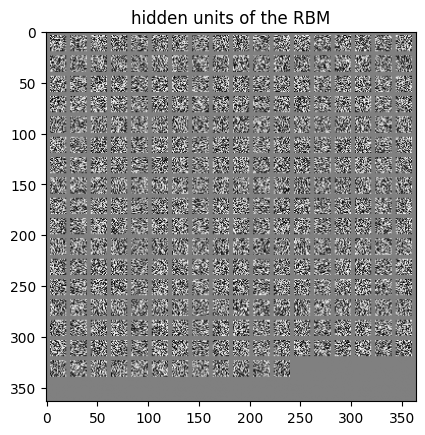

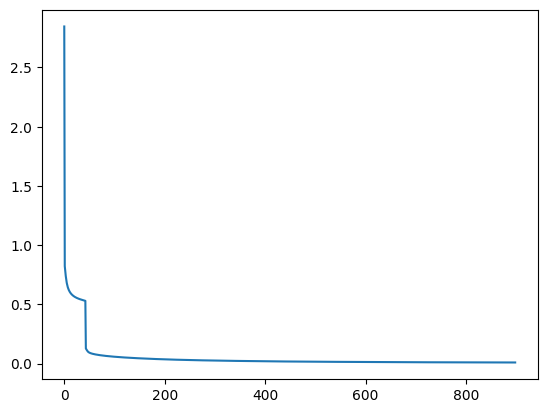

In [6]:
a4_main(300, .0, .005, 1000)

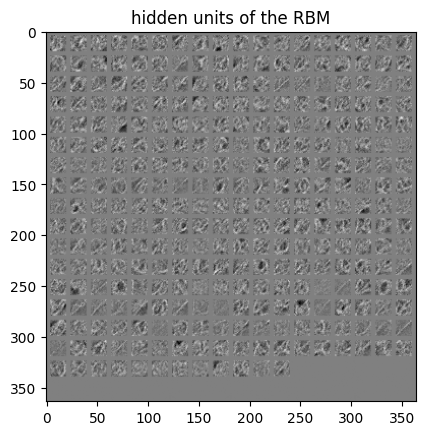

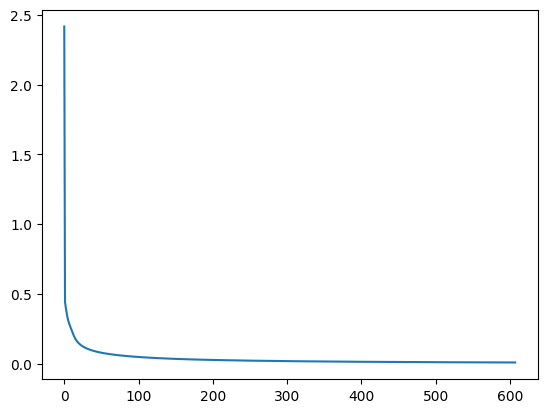

In [7]:
a4_main(300, .02, .005, 1000)
